In [12]:
import pandas
import seaborn
import matplotlib.pyplot as plt

## Ingeneria de datos

In [2]:
MajorCityCSV = 'GlobalLandTemperaturesByMajorCity.csv'

In [3]:
# engine: para seleccionar la libreria que abre el archivo
# pyarrow para archivos muy grandes
# dtype_backend: como se almacenan los datos

MajorCityDF = pandas.read_csv(
    MajorCityCSV,
    engine='pyarrow',
    dtype_backend='pyarrow'
)

In [4]:
MajorCityDF.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.14,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.2,Abidjan,Côte D'Ivoire,5.63N,3.23W


In [5]:
MajorCityDF.describe()

,dt,AverageTemperature,AverageTemperatureUncertainty
count,239177,228175.0,228175.0
mean,1910-11-09,18.125969,0.969343
min,1743-11-01,-26.772,0.04
25%,1864-02-01,12.71,0.34
50%,1914-02-01,20.428,0.592
75%,1963-12-01,25.918,1.32
max,2013-09-01,38.283,14.037
std,NaN,10.0248,0.979644


In [6]:
MajorCityDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239177 entries, 0 to 239176
Data columns (total 7 columns):
 #   Column                         Non-Null Count   Dtype               
---  ------                         --------------   -----               
 0   dt                             239177 non-null  date32[day][pyarrow]
 1   AverageTemperature             228175 non-null  double[pyarrow]     
 2   AverageTemperatureUncertainty  228175 non-null  double[pyarrow]     
 3   City                           239177 non-null  string[pyarrow]     
 4   Country                        239177 non-null  string[pyarrow]     
 5   Latitude                       239177 non-null  string[pyarrow]     
 6   Longitude                      239177 non-null  string[pyarrow]     
dtypes: date32[day][pyarrow](1), double[pyarrow](2), string[pyarrow](4)
memory usage: 14.3 MB


El archivo MajorCityDF con 7 columnas y 239177 filas, nos entrega informacion sobre las fechas (df), temperatura promedio (AverageTemperature), incertidumbre de la temperatura promedio (AverageTemperatureUncertanity), nombre de la ciudad (City), pais (Country), latitud (Latitude) y longitud (Longitude).

In [37]:
MajorCityDF.duplicated().sum() # buscar datos duplicados
MajorCityDF.isna().sum() # buscar valores NaN

dt                                   0
AverageTemperature               11002
AverageTemperatureUncertainty    11002
City                                 0
Country                              0
Latitude                             0
Longitude                            0
year                                 0
month                                0
dtype: int64

No hay datos duplicados, pero si hay 11002 datos de AverageTemperature y AverageTemperatureUncertainty tipo NaN. Se eliminan las filas que contengas datos NaN y se actualiza el dataset original.

In [39]:
MajorCityDF = MajorCityDF.dropna()
MajorCityDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 228175 entries, 0 to 239175
Data columns (total 9 columns):
 #   Column                         Non-Null Count   Dtype               
---  ------                         --------------   -----               
 0   dt                             228175 non-null  date32[day][pyarrow]
 1   AverageTemperature             228175 non-null  double[pyarrow]     
 2   AverageTemperatureUncertainty  228175 non-null  double[pyarrow]     
 3   City                           228175 non-null  string[pyarrow]     
 4   Country                        228175 non-null  string[pyarrow]     
 5   Latitude                       228175 non-null  string[pyarrow]     
 6   Longitude                      228175 non-null  string[pyarrow]     
 7   year                           228175 non-null  int64[pyarrow]      
 8   month                          228175 non-null  int64[pyarrow]      
dtypes: date32[day][pyarrow](1), double[pyarrow](2), int64[pyarrow](2), string[py

In [7]:
# se crea esta columna para obtener un valor promedio por año de las temperaturas
# columna.dt.year = extrae el año
MajorCityDF['year'] = MajorCityDF["dt"].dt.year

# Y esta otra lo mismo pero por mes
# columna.dt.month
MajorCityDF['month'] = MajorCityDF["dt"].dt.month

In [8]:
MajorCityDF.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,year,month
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849,1
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849,2
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849,3
3,1849-04-01,26.14,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849,4
4,1849-05-01,25.427,1.2,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849,5


In [9]:
# Analizamos la cantidad de datos por cada pais
print(MajorCityDF.value_counts('Country').head(3))
print(MajorCityDF.value_counts('Country').tail(3))
print(f'total: {MajorCityDF.value_counts('Country').shape[0]}')

Country
India     36582
China     35444
Brazil    12930
Name: count, dtype: int64
Country
Angola    1893
Sudan     1857
Peru      1591
Name: count, dtype: int64
total: 49


In [10]:
# Analizamos la cantidad de datos por cada ciudad
print(MajorCityDF.value_counts('City').head(3))
print(MajorCityDF.value_counts('City').tail(3))
print(f'total: {MajorCityDF.value_counts('City').shape[0]}')

City
Chicago    3239
Berlin     3239
Kiev       3239
Name: count, dtype: int64
City
Cape Town     1881
Umm Durman    1857
Lima          1591
Name: count, dtype: int64
total: 100


<Axes: xlabel='year', ylabel='AverageTemperature'>

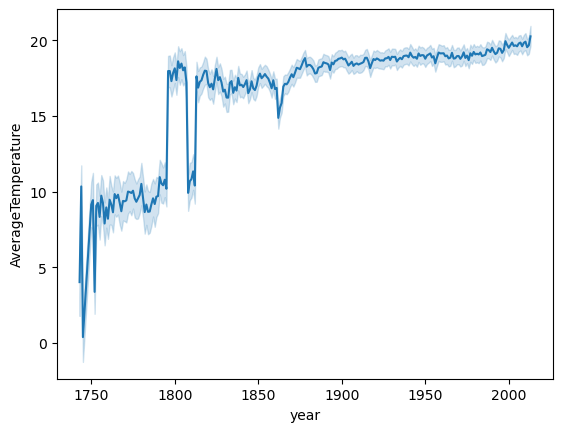

In [11]:
# Temperatura por año
seaborn.lineplot(
    data = MajorCityDF,
    x='year',
    y='AverageTemperature',
)

In [34]:
def yr_vs_temp(country):
    """
    input: pais
    output: plot de temperatura por año para el pais
    """
    df_country = MajorCityDF[MajorCityDF['Country'] == country]

    plt.figure(figsize=(10, 5))
    plt.plot(df_country['year'], df_country['AverageTemperature'])
    plt.xlabel('Year')
    plt.ylabel('Average Temperature')
    plt.title(f"Average Temperature in {country}")
    plt.show()

def yr_vs_temp_lineplot(country):
    """
    input: pais
    output: lineplot de temperatura por año para el pais
    """
    df_country = MajorCityDF[MajorCityDF['Country'] == country]

    seaborn.lineplot(data = df_country, x='year', y='AverageTemperature')
    plt.title(f"Average Temperature in {country}")
    plt.show()

def month_vs_temp_lineplot(country):
    """
    input: pais
    output: lineplot de temperatura por mes para el pais
    """
    df_country = MajorCityDF[MajorCityDF['Country'] == country]

    seaborn.lineplot(data = df_country, x='month', y='AverageTemperature')
    plt.title(f"Average Temperature in {country}")
    plt.show()

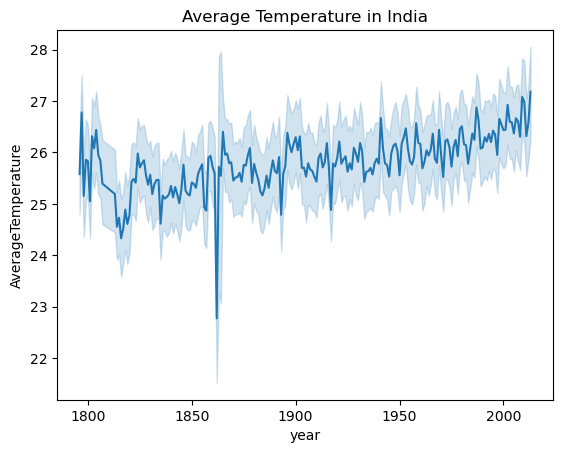

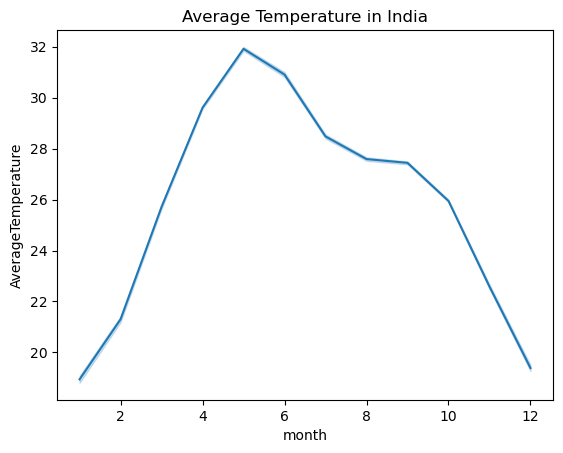

In [35]:
data_yr = yr_vs_temp_lineplot('India')
data_month = month_vs_temp_lineplot('India')